### Project Objective

The goal of this analysis is to quantify the isolated impact of schedule difficulty on an NBA team's regular-season performance. Specifically, this project seeks to determine how many wins a team gained or lost purely due to its schedule's structure (opponent strength, travel, and rest days), independent of the team's inherent quality.

### Methodology Overview

To achieve this, an Ordinary Least Squares (OLS) regression model with team and season fixed effects was developed to predict individual game outcomes. The model's predictions for each team's actual schedule were then compared against a counterfactual "neutral" schedule baseline. The difference between these two scenarios reveals the net number of wins attributable solely to schedule variance.

### Executive Summary: Key Findings

The analysis revealed that schedule difficulty can account for a swing of several wins over a season. For instance, across the five seasons analyzed (2019-2024), teams like the Los Angeles Clippers consistently faced one of the league's toughest schedules, costing them an estimated 4-5 wins, while teams like the Utah Jazz benefited from comparatively lighter schedules. The model confirms that while team strength is the primary driver of wins, schedule luck is a statistically significant factor in a team's final record.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.formula.api as smf

schedule = pd.read_csv("schedule.csv")
draft_schedule = pd.read_csv("schedule_24_partial.csv")
locations = pd.read_csv("locations.csv")
game_data = pd.read_csv("team_game_data.csv")

### Schedule Trends Across the 2013-14 season to 2023-2024 season
In response to concerns over player health and fan engagement, the NBA has strategically reduced schedule density. This policy directly addresses the challenges of "load management" by providing more rest, which is intended to mitigate injury risk and ensure the league's top talent is featured more consistently.

The following section will test this claim by analyzing historical schedule data to verify if there has been a measurable reduction in high-density game situations.

### Definition of 'Hight Density Games' in the NBA
It is a compressed period of the schedule where a team plays multiple games in a short timeframe with minimal rest. This concept is a key indicator of schedule difficulty and is closely studied to understand its impact on player fatigue, injury risk, and on-court performance.

High-density situations are typically characterized by:

* Back-to-Backs: The most common form of schedule density, where a team plays games on two consecutive nights.

* Compressed Stretches: Scenarios where teams play multiple games with less than the standard one day of rest in between, such as playing "4 games in 6 nights" or the more grueling "4 games in 5 nights."

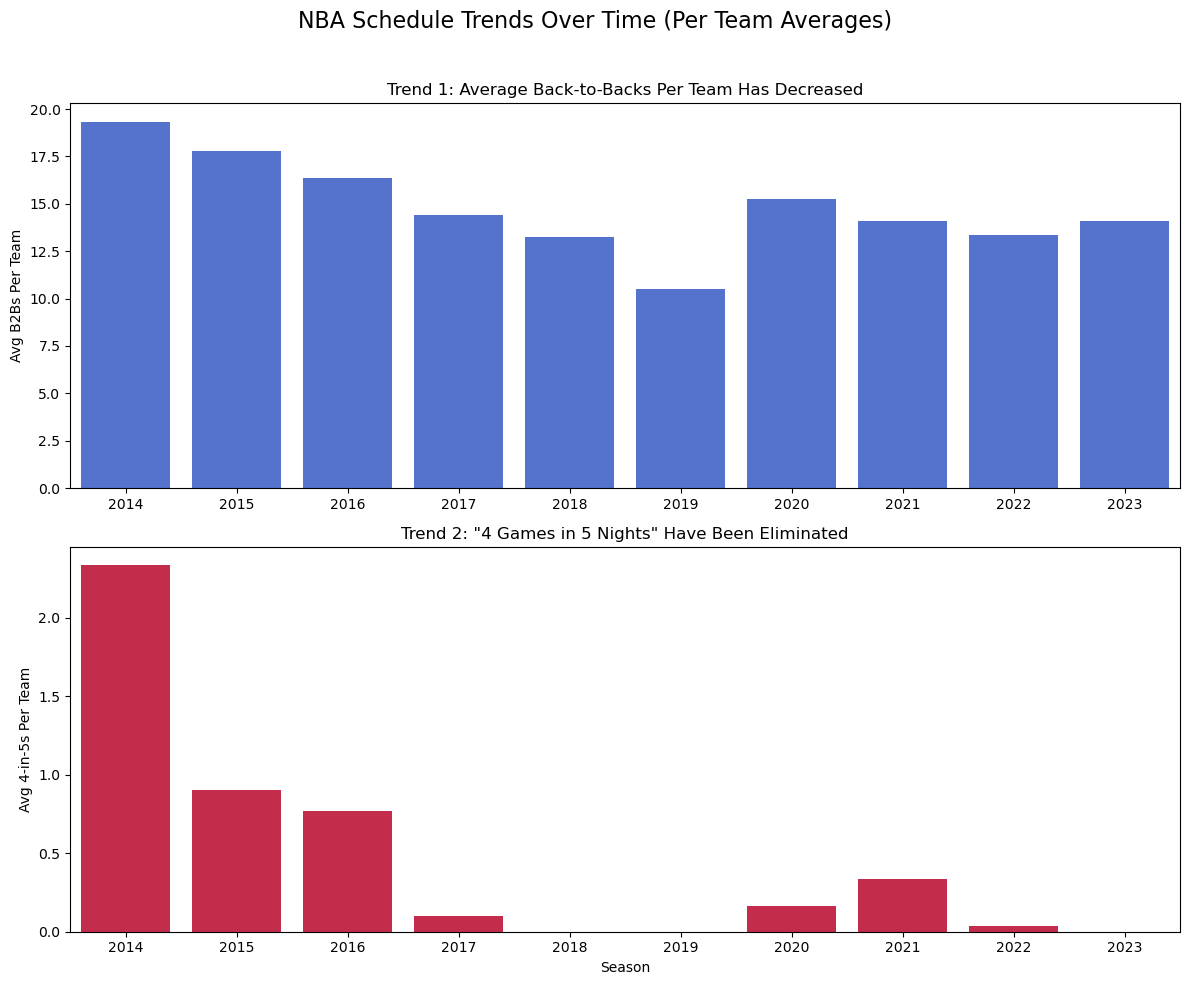

In [62]:
schedule['gamedate'] = pd.to_datetime(schedule['gamedate'])

# Sort values to ensure calculations are done chronologically for each team
schedule = schedule.sort_values(by=['team', 'season', 'gamedate']).reset_index(drop=True)

# Calculate Back-to-Backs (B2Bs)
schedule['days_since_last_game'] = schedule.groupby(['team', 'season'])['gamedate'].diff().dt.days
schedule['is_b2b'] = (schedule['days_since_last_game'] == 1)

# Calculate "4 Games in 5 Nights"
schedule['game_count'] = 1
games_in_5_days = schedule.set_index('gamedate').groupby(['team', 'season'])['game_count'].rolling(window='5D').sum()
schedule['games_in_5_days'] = games_in_5_days.reset_index(drop=True).values
schedule['is_4_in_5'] = (schedule['games_in_5_days'] == 4)

# Aggregate Data by Season
teams_per_season = schedule.groupby('season')['team'].nunique()
b2b_by_season = schedule.groupby('season')['is_b2b'].sum()
four_in_five_by_season = schedule.groupby('season')['is_4_in_5'].sum()

trends_df = pd.DataFrame({
    'avg_b2b_per_team': b2b_by_season / teams_per_season,
    'avg_4in5_per_team': four_in_five_by_season / teams_per_season
}).reset_index()

# Visualization with Seaborn and Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('NBA Schedule Trends Over Time (Per Team Averages)', fontsize=16)

# Plot for B2Bs
sns.barplot(
    x='season',
    y='avg_b2b_per_team',
    data=trends_df,
    ax=ax1,
    color='royalblue'
)
ax1.set_title('Trend 1: Average Back-to-Backs Per Team Has Decreased')
ax1.set_ylabel('Avg B2Bs Per Team')
ax1.set_xlabel('') # Hide x-label to avoid repetition

# Plot for 4-in-5s
sns.barplot(
    x='season',
    y='avg_4in5_per_team',
    data=trends_df,
    ax=ax2,
    color='crimson'
)
ax2.set_title('Trend 2: "4 Games in 5 Nights" Have Been Eliminated')
ax2.set_ylabel('Avg 4-in-5s Per Team')
ax2.set_xlabel('Season')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Clear Reduction in High Density Schedules 
The data shows a clear reduction in back-to-backs and the near-elimination of the grueling "4 games in 5 nights" schedule. However, it also captures anomalies, such as the temporary re-emergence of high-density stretches during the 2020-22 seasons, which were compressed due to the COVID-19 pandemic.

### Looking into the Teams - Which Team has the Highest Density Schedule in the Past 10 Seasons? 
While the league-wide data confirms the NBA's efforts, these averages don't impact all teams equally. To identify which franchises have faced the most demanding schedules, the following section provides a team-by-team breakdown of high-density "4 games in 6 nights" stretches over the past ten seasons.

In [55]:
# Ensure 'gamedate' is a datetime type, set it as the index and sort by teams for calculation 
schedule['gamedate'] = pd.to_datetime(schedule['gamedate'])
schedule = schedule.sort_values(by = ['team','gamedate'], ascending = True).reset_index(drop = True)
schedule['gamesplayed'] = 1

# Set the index to gamedate for time-based operations
schedule_indexed = schedule.set_index('gamedate')
# Use time-based rolling with groupby
games_in_6_nights_by_team = schedule_indexed.groupby('team')['gamesplayed'].rolling('6D').sum()
four_in_six_count_by_team = (games_in_6_nights_by_team == 4).groupby('team').sum()

# Turn result to pandas for further calculation
stretches_df = pd.DataFrame(four_in_six_count_by_team)

In [66]:
# Get total games played by team
total_games_played_by_team = schedule.groupby('team')['gamesplayed'].sum()
total_games_played_by_team_df = pd.DataFrame(total_games_played_by_team)

# Merge two datasets for calculation
avg_stretches = pd.merge(stretches_df, total_games_played_by_team_df, on = 'team', how = 'inner', suffixes = ('_stretches', '_total'))
avg_stretches['adjusted_stretches_played_per_season'] = (avg_stretches['gamesplayed_stretches']/ avg_stretches['gamesplayed_total'] * 82).round(1)

avg_stretches.sort_values(by = 'adjusted_stretches_played_per_season', ascending = False)

,gamesplayed_stretches,gamesplayed_total,adjusted_stretches_played_per_season
team,,,
CHA,271,793,28.0
CHI,270,793,27.9
POR,263,802,26.9
DET,256,794,26.4
LAC,258,800,26.4
ATL,255,795,26.3
IND,256,801,26.2
WAS,256,800,26.2
OKC,254,800,26.0


Surprisingly, the Charlotte Hornets have the most "4 games in 6 nights" game schedules of all NBA teams, while New York Knicks have the fewest

The analysis reveals a significant disparity in schedule density across the league. Over the past decade, the Charlotte Hornets have endured the highest number of grueling "4 games in 6 nights" stretches, while the New York Knicks have faced the fewest. This finding underscores that schedule difficulty is not uniform and highlights how factors beyond a team's control, such as arena availability and geographical location, can create inherent disadvantages before the season even begins. This variance is precisely what the subsequent regression model aims to quantify in terms of wins and losses.

### Modeling the Impact of Schedule Difficulty on Game Outcomes
To move beyond descriptive analysis and quantify the precise impact of the schedule, an Ordinary Least Squares (OLS) regression model was constructed. The model is designed to predict the outcome of individual games based on schedule-related variables while controlling for the inherent quality of each team and league-wide variations across seasons.

Model Specification

The model estimates the probability of a win for each game played between the 2014-15 and 2023-24 seasons.

Dependent Variable: The outcome of each game, represented as a binary variable (Win = 1, Loss = 0).

Independent Variables (Schedule Factors):

Opponent Strength: Measured as the opponent's full-season win rate. To prevent circularity (where a game's outcome influences the opponent's win rate, which then predicts the game's outcome), this is calculated using a leave-one-out method, excluding the current game.

Days of Rest: A numerical value for the number of rest days a team had before the game, capturing immediate fatigue.

Schedule Density: The total number of games a team played in the 6 days prior to the current game. This variable measures the cumulative fatigue from a congested schedule.

Control Variables (Fixed Effects):

Team Fixed Effects: These control for the constant, unobserved quality of each franchise, such as roster talent, coaching staff, organizational culture, and home-court advantage. This is crucial for isolating the schedule's effect from the team's baseline strength.

Season Fixed Effects: These account for any league-wide variations from one season to the next, such as the shortened 2020-21 season, rule changes, or shifts in playing style.

By including these fixed effects, the model can more accurately isolate the marginal impact of the schedule variables on a team's likelihood of winning any given game. The final output of this model provides the foundation for the counterfactual analysis.

                            OLS Regression Results                            
Dep. Variable:                    win   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     68.83
Date:                Mon, 20 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:48:30   Log-Likelihood:                -16052.
No. Observations:               23958   AIC:                         3.219e+04
Df Residuals:                   23916   BIC:                         3.253e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9523      0.03

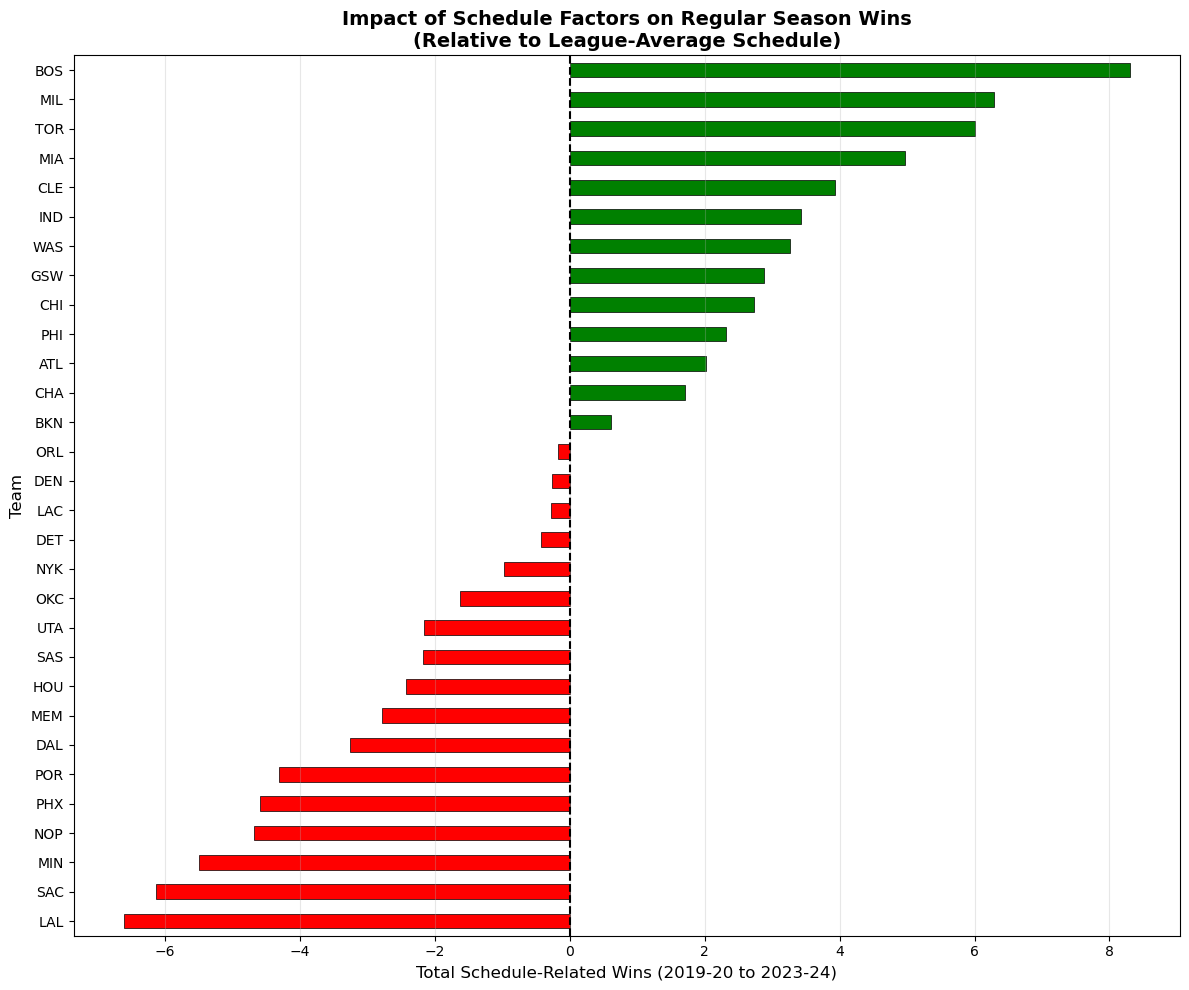

In [79]:
import statsmodels.formula.api as smf

# Ensure proper data types
schedule['gamedate'] = pd.to_datetime(schedule['gamedate'])
schedule['season'] = schedule['season'].astype(str)
schedule['home'] = schedule['home'].astype(int)
schedule['win'] = schedule['win'].astype(int)

# Sort by team and date
schedule = schedule.sort_values(['team', 'gamedate']).reset_index(drop=True)

# ============================================
# STEP 1: Calculate opponent strength
# ============================================
season_team_wins = schedule.groupby(['season', 'team'])['win'].agg(['sum', 'count']).reset_index()
season_team_wins['win_rate'] = season_team_wins['sum'] / season_team_wins['count']
opponent_strength_map = season_team_wins.set_index(['season', 'team'])['win_rate'].to_dict()

schedule['opponent_strength'] = schedule.apply(
    lambda row: opponent_strength_map.get((row['season'], row['opponent']), 0.5), 
    axis=1
)

# ============================================
# STEP 2: Calculate rest/schedule features
# ============================================
schedule['days_rest'] = schedule.groupby('team')['gamedate'].diff().dt.days
schedule['days_rest'] = schedule['days_rest'].fillna(3)
schedule['days_rest'] = schedule['days_rest'].clip(upper=7)

# Calculate schedule density: number of games in last 6 days
schedule['games_last_6_days'] = 0
for team in schedule['team'].unique():
    team_mask = schedule['team'] == team
    team_dates = schedule.loc[team_mask, 'gamedate']
    
    for idx in schedule[team_mask].index:
        current_date = schedule.loc[idx, 'gamedate']
        recent_games = ((team_dates < current_date) & 
                       (team_dates >= current_date - pd.Timedelta(days=6))).sum()
        schedule.loc[idx, 'games_last_6_days'] = recent_games

# ============================================
# STEP 3: Fit GAME-LEVEL regression model
# ============================================
# Model uses ONLY days_rest (not back-to-back) to avoid multicollinearity
formula = '''win ~ opponent_strength + days_rest + 
             games_last_6_days + C(team) + C(season)'''

model = smf.ols(formula, data = schedule).fit()

print(model.summary())

# ============================================
# STEP 4: Calculate schedule-related wins
# ============================================

schedule['predicted_win_actual'] = model.predict(schedule)

# Create neutral schedule with league averages
schedule_neutral = schedule.copy()
schedule_neutral['opponent_strength'] = schedule['opponent_strength'].mean()
schedule_neutral['days_rest'] = schedule['days_rest'].mean()
schedule_neutral['games_last_6_days'] = schedule['games_last_6_days'].mean()

schedule['predicted_win_neutral'] = model.predict(schedule_neutral)
schedule['schedule_advantage_per_game'] = schedule['predicted_win_actual'] - schedule['predicted_win_neutral']

total_schedule_wins = schedule.groupby('team')['schedule_advantage_per_game'].sum().sort_values()

print("=" * 80)
print("TOTAL SCHEDULE-RELATED WINS (2019-20 through 2023-24)")
print("=" * 80)

# Most hurt (ascending order: most negative to least negative)
most_hurt = total_schedule_wins.head(10).round(1)
print("\n⬇️  MOST HURT BY SCHEDULE (Hardest schedules):")
print(most_hurt.to_string())

# Most helped (descending order: most positive to least positive)
most_helped = total_schedule_wins.tail(10).sort_values(ascending=False).round(1)
print("\n⬆️  MOST HELPED BY SCHEDULE (Easiest schedules):")
print(most_helped.to_string())
print("\n")

# ============================================
# STEP 5: Visualizations
# ============================================
plt.figure(figsize=(12, 10))
colors = ['red' if x < 0 else 'green' for x in total_schedule_wins.values]
total_schedule_wins.plot(kind='barh', color=colors, edgecolor='black', linewidth=0.5)
plt.xlabel('Total Schedule-Related Wins (2019-20 to 2023-24)', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title('Impact of Schedule Factors on Regular Season Wins\n(Relative to League-Average Schedule)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

### Interpreting the Regression Coefficients

The model summary provides insight into the factors that influence game outcomes. The overall model is statistically significant (F-statistic Prob = 0.00), and the Adjusted R-squared value of 0.104 indicates that the model explains approximately 10.4% of the variance in game outcomes. While many factors contribute to winning a basketball game, this R-squared value confirms that the included variables have a meaningful explanatory power.

#### The coefficients for the key schedule-related variables

* opponent_strength `(-0.9948)`: This is the most influential predictor in the model and is highly statistically significant (p < 0.001). The negative coefficient confirms the obvious basketball logic: as an opponent's quality increases, a team's probability of winning decreases substantially.

* days_rest `(0.0144)`: This variable is also statistically significant (p < 0.001). The positive coefficient indicates that for each additional day of rest a team has, its probability of winning increases slightly. This provides quantitative evidence that rest has a direct, positive impact on performance.

* games_last_6_days `(-0.0010`): Interestingly, this variable is not statistically significant (p = 0.849). This suggests that, after controlling for immediate rest (days_rest), the cumulative number of games in the past week does not have a strong independent effect on the outcome of the next game. Immediate fatigue appears to be a more important factor than lingering fatigue in this model.

#### Counterfactual Analysis: Quantifying the Total Impact of the Schedule

The primary goal of this project was to translate the model's findings into a tangible number: total wins gained or lost due to schedule luck. By comparing each team's predicted performance under their actual schedule versus a neutral one, we can isolate this effect.

* The results over the five-season period are clear:

    * Most Hurt by Schedule: The Los Angeles Lakers were the most disadvantaged team, losing an estimated 6.6 wins due to their difficult schedules. They were followed by other Western Conference teams like the Sacramento Kings (-6.1 wins) and the Minnesota Timberwolves (-5.5 wins).

    * Most Helped by Schedule: Conversely, the Boston Celtics benefited the most, gaining an estimated 8.3 wins from having a comparatively favorable schedule. Other Eastern Conference powerhouses like the Milwaukee Bucks (+6.3 wins) and Toronto Raptors (+6.0 wins) also received a significant boost.

These findings confirm the project's central hypothesis: while team quality is paramount, the structure of a team's schedule is a significant and quantifiable factor that can alter the landscape of the regular season standings by several wins.

### Practical Application: The Seasonal Schedule Dashboard
With the importance of schedule difficulty clearly established, the next logical step is to create a tool for a more granular, team-specific analysis. The following Python function, analyze_schedule, generates a comprehensive dashboard for any given team and season.

This visualization tool synthesizes the key metrics of the analysis into three distinct views:

Game Density & Travel Load: Visualizes the most demanding stretches of the season.

Rest Days Analysis: Highlights periods of fatigue and recovery.

Performance Trends: Tracks the team's rolling win percentage to correlate performance with the schedule.

This dashboard serves as a practical application of the model's findings, allowing coaches, analysts, and fans to explore the unique challenges of a team's schedule throughout a season.

In [80]:
def analyze_schedule(df: pd.DataFrame, team_name: str, season: int):
    """
    Comprehensive schedule visualization with multiple views:
    1. Game density and travel
    2. Rest days analysis
    3. Performance trends
    """

    # Filter and prepare data
    team_schedule = df[(df['team'] == team_name) & (df['season'] == season)].copy()
    team_schedule['gamedate'] = pd.to_datetime(team_schedule['gamedate'])
    team_schedule = team_schedule.sort_values('gamedate').reset_index(drop=True)

    if team_schedule.empty:
        print(f"No data found for {team_name} in season {season}")
        return None

    # Calculate key metrics
    team_schedule['days_rest'] = team_schedule['gamedate'].diff().dt.days.fillna(0)
    team_schedule['location_change'] = (team_schedule['home'] != team_schedule['home'].shift()).astype(int)
    team_schedule['game_num'] = range(1, len(team_schedule) + 1)
    
    # Rolling metrics - set gamedate as index for time-based rolling
    team_schedule_indexed = team_schedule.set_index('gamedate')
    team_schedule['games_in_6days'] = team_schedule_indexed.rolling(
        window='6D'
    )['game_num'].count().values

    # Fixed-window rolling for win percentage (past 10 days)
    team_schedule['win_pct_last10'] = team_schedule['win'].rolling(
        window=10, min_periods=1
    ).mean() * 100 

    # Create figure with 3 subplots
    fig = make_subplots(
        rows=3, cols=1,
        row_heights=[0.3, 0.3, 0.4],
        subplot_titles=(
            'Game Density & Travel Load',
            'Days Between Games',
            'Rolling Win % (Last 10 Games)'
        ),
        vertical_spacing=0.1,
        specs=[[{"secondary_y": True}],
               [{"secondary_y": False}],
               [{"secondary_y": False}]]
    )

    # ========== SUBPLOT 1: Game Density ==========
    fig.add_trace(go.Scatter(
        x=team_schedule['gamedate'],
        y=team_schedule['games_in_6days'],
        mode='lines+markers',
        name='Games in 6 Days',
        line=dict(color='purple', width=2),
        marker=dict(size=6),
        hovertemplate='%{y:.0f} games in past 6 days<br>%{x}<extra></extra>'
    ), row=1, col=1)

    # travel indicator (location changes)
    travel_days = team_schedule[team_schedule['location_change'] == 1]
    fig.add_trace(go.Scatter(
        x=travel_days['gamedate'],
        y=[0.5] * len(travel_days),
        mode='markers',
        marker=dict(size=10, color='orange', symbol='arrow-up'),
        name='Location Change',
        hovertemplate='Travel Day<br>%{x}<extra></extra>',
    ), row=1, col=1, secondary_y=True)

    # ========== SUBPLOT 2: Rest Days ==========
    fig.add_trace(go.Bar(
        x=team_schedule['gamedate'],
        y=team_schedule['days_rest'],
        marker=dict(
            color=team_schedule['days_rest'],
            colorscale=[[0, 'red'], [0.5, 'yellow'], [1, 'green']],
            cmin=0,
            cmax=5,
            showscale=True,
            colorbar=dict(title='Days', len=0.25, y=0.45)
        ),
        name='Days Rest',
        hovertemplate='%{y:.0f} days rest<br>%{x}<extra></extra>'
    ), row=2, col=1)

    # ========== SUBPLOT 3: Rolling Win % ==========
    fig.add_trace(go.Scatter(
        x=team_schedule['gamedate'],
        y=team_schedule['win_pct_last10'],
        mode='lines',
        fill='tozeroy',
        name='Win % (L10)',
        line=dict(color='teal', width=2),
        fillcolor='rgba(0, 128, 128, 0.2)',
        hovertemplate='Win %: %{y:.1f}%<br>%{x}<extra></extra>'
    ), row=3, col=1)

    # 50% reference line
    fig.add_hline(y=50, line_dash="dash", line_color="gray", row=3, col=1,
                  annotation_text="50%", annotation_position="right")

    # ========== Layout Updates ==========
    fig.update_xaxes(title_text='Date', row=3, col=1)
    fig.update_yaxes(title_text="Games", row=1, col=1)
    fig.update_yaxes(title_text="Travel", showticklabels=False, row=1, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Days", row=2, col=1)
    fig.update_yaxes(title_text="Win %", row=3, col=1)

    # Overall layout
    fig.update_layout(
        height=850, # Adjusted height for 3 plots
        title=dict(
            text=f"{team_name} Season {season}-{season+1} Schedule Analysis",
            x=0.5,
            xanchor='center',
            font=dict(size=20)
        ),
        hovermode='x unified',
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='center',
            x=0.5
        )
    )

    # Add annotations for insights
    total_games = len(team_schedule)
    total_b2b = (team_schedule['days_rest'] == 1).sum()
    max_density = team_schedule['games_in_6days'].max()
    win_pct = (team_schedule['win'].sum() / total_games * 100)

    annotation_text = (
        f"<b>Season Summary:</b> {total_games} games | "
        f"{total_b2b} back-to-backs | "
        f"Max: {max_density:.0f} games in 6 days | "
        f"Overall Win%: {win_pct:.1f}%"
    )

    fig.add_annotation(
        text=annotation_text,
        xref='paper', yref='paper',
        x=0.5, y=-0.12,
        showarrow=False,
        font=dict(size=12),
        xanchor='center'
    )

    return fig

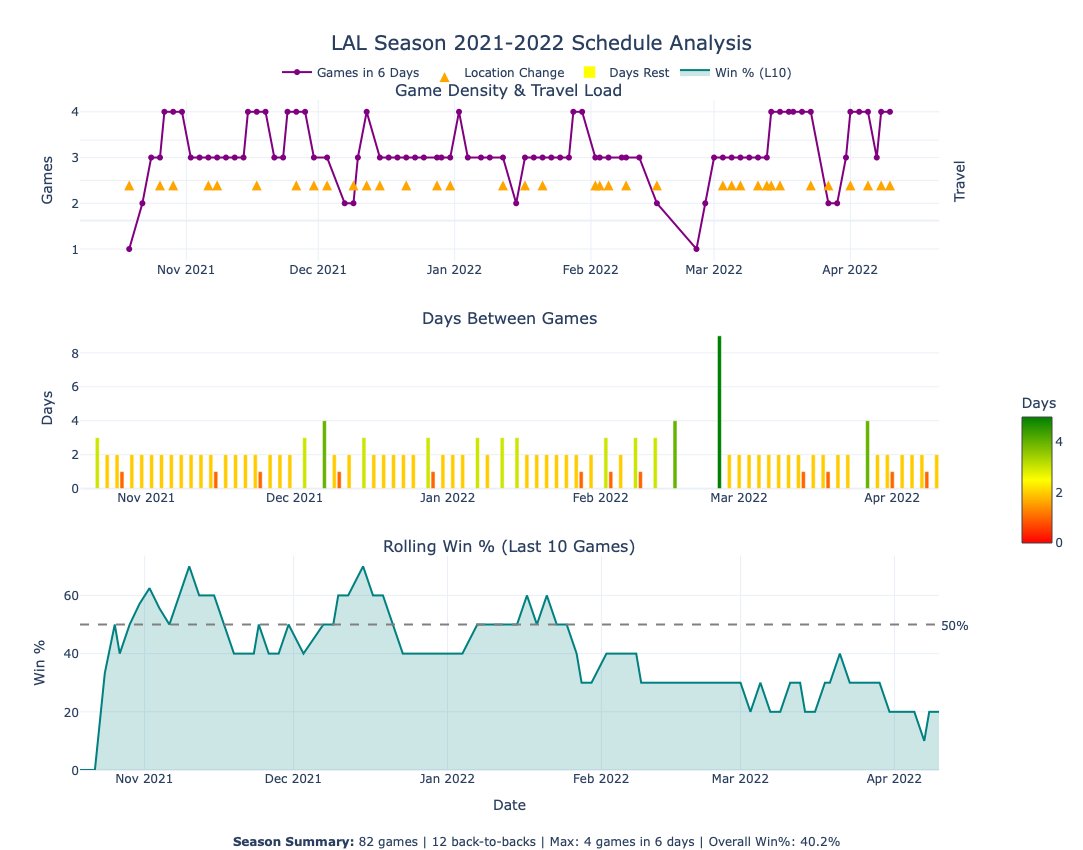

In [84]:
analyze_schedule(schedule, 'LAL', 2021)

<h5> Team Initials for Reference</h5>

<div style="display: flex; flex-direction: row; justify-content: space-between;">    
  <div style="flex: 1; padding-right: 10px;">
    <h4>Western Conference</h4>
    <table>
      <thead>
        <tr>
          <th>Team</th>
          <th>Initial</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>Dallas Mavericks</td>
          <td>DAL</td>
        </tr>
        <tr>
          <td>Denver Nuggets</td>
          <td>DEN</td>
        </tr>
        <tr>
          <td>Golden State Warriors</td>
          <td>GSW</td>
        </tr>
        <tr>
          <td>Houston Rockets</td>
          <td>HOU</td>
        </tr>
        <tr>
          <td>Los Angeles Clippers</td>
          <td>LAC</td>
        </tr>
        <tr>
          <td>Los Angeles Lakers</td>
          <td>LAL</td>
        </tr>
        <tr>
          <td>Memphis Grizzlies</td>
          <td>MEM</td>
        </tr>
        <tr>
          <td>Minnesota Timberwolves</td>
          <td>MIN</td>
        </tr>
        <tr>
          <td>New Orleans Pelicans</td>
          <td>NOP</td>
        </tr>
        <tr>
          <td>Oklahoma City Thunder</td>
          <td>OKC</td>
        </tr>
        <tr>
          <td>Phoenix Suns</td>
          <td>PHX</td>
        </tr>
        <tr>
          <td>Portland Trail Blazers</td>
          <td>POR</td>
        </tr>
        <tr>
          <td>Sacramento Kings</td>
          <td>SAC</td>
        </tr>
        <tr>
          <td>San Antonio Spurs</td>
          <td>SAS</td>
        </tr>
        <tr>
          <td>Utah Jazz</td>
          <td>UTA</td>
        </tr>
      </tbody>
    </table>
  </div>

  <div style="flex: 1; padding-left: 10px;">
    <h4>Eastern Conference</h4>
    <table>
      <thead>
        <tr>
          <th>Team</th>
          <th>Initial</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>Atlanta Hawks</td>
          <td>ATL</td>
        </tr>
        <tr>
          <td>Boston Celtics</td>
          <td>BOS</td>
        </tr>
        <tr>
          <td>Brooklyn Nets</td>
          <td>BKN</td>
        </tr>
        <tr>
          <td>Charlotte Hornets</td>
          <td>CHA</td>
        </tr>
        <tr>
          <td>Chicago Bulls</td>
          <td>CHI</td>
        </tr>
        <tr>
          <td>Cleveland Cavaliers</td>
          <td>CLE</td>
        </tr>
        <tr>
          <td>Detroit Pistons</td>
          <td>DET</td>
        </tr>
        <tr>
          <td>Indiana Pacers</td>
          <td>IND</td>
        </tr>
        <tr>
          <td>Miami Heat</td>
          <td>MIA</td>
        </tr>
        <tr>
          <td>Milwaukee Bucks</td>
          <td>MIL</td>
        </tr>
        <tr>
          <td>New York Knicks</td>
          <td>NYK</td>
        </tr>
        <tr>
          <td>Orlando Magic</td>
          <td>ORL</td>
        </tr>
        <tr>
          <td>Philadelphia 76ers</td>
          <td>PHI</td>
        </tr>
        <tr>
          <td>Toronto Raptors</td>
          <td>TOR</td>
        </tr>
        <tr>
          <td>Washington Wizards</td>
          <td>WAS</td>
        </tr>
      </tbody>
    </table>
  </div>

</div>